In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/validation_data_chatbot.csv
/kaggle/input/dataset/train_data_chatbot.csv
/kaggle/input/latest-model-qa/checkpoint_dir/checkpoint_dir/medical_qa_model_epoch_02_val_acc_0.5503.weights.h5
/kaggle/input/latest-model-qa/checkpoint_dir/checkpoint_dir/medical_qa_model_epoch_05_val_acc_0.5566.weights.h5
/kaggle/input/latest-model-qa/checkpoint_dir/checkpoint_dir/medical_qa_model_epoch_04_val_acc_0.5539.weights.h5
/kaggle/input/latest-model-qa/checkpoint_dir/checkpoint_dir/medical_qa_model_epoch_01_val_acc_0.5426.weights.h5
/kaggle/input/latest-model-qa/2nd model/2nd model/medic2_0.5517415404319763.weights.h5
/kaggle/input/latest-model-qa/2nd model/2nd model/medic3_0.552686870098114.weights.h5
/kaggle/input/latest-model-qa/2nd model/2nd model/medic4_0.5572245121002197.weights.h5


In [3]:
!pip install contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.9 MB/s eta 0:00:00


In [11]:
!git clone https://github.com/LasseRegin/medical-question-answer-data.git

Cloning into 'medical-question-answer-data'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22 (from 1)
Receiving objects: 100% (22/22), 26.71 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import contractions
import re

In [4]:
import json
import os

In [5]:
from transformers import AutoModelForSequenceClassification
# Load BioBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")
biobert = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2",num_labels=1)

# Configurations
MAX_SEQ_LEN = 512  # Maximum sequence length for BioBERT
BATCH_SIZE = 8
EPOCHS = 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Load JSON medical data files from a directory
def load_json_data(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r') as file:
                data.extend(json.load(file))
    return data

In [7]:
# Extract questions, answers, and tags from JSON objects
def extract_qa_data(json_data):
    questions, answers, tags = [], [], []
    for item in json_data:
        questions.append(item["question"])
        answers.append(item["answer"])
        tags.append(item["tags"])
    return pd.DataFrame({'question': questions, 'answer': answers, 'tags': tags})

In [8]:
# Example usage
json_data = load_json_data('../medical-question-answer-data')
qa_df = extract_qa_data(json_data)
print("Extracted Data Sample:\n", qa_df.head())

Extracted Data Sample:
                                             question  \
0                          how do i stop smoking now   
1  i had a tubaligation 4 years ago and also have...   
2  could extra caffeine consumption be a cause of...   
3  hello- i am a 24 year old female 5"4 & 115 lb ...   
4  i was wanting to know if you could tell me if ...   

                                              answer  \
0  stopping smoking is about will power and being...   
1  hello this sounds quite unfamiliar that due to...   
2  extra caffeine can cause gastric discomfort th...   
3  hello thanks for submitting your question here...   
4  i am glad to help you out. this is not possibl...   

                                                tags  
0                          [addiction, stop smoking]  
1                   [pregnancy, diet, endometriosis]  
2                   [breast cancer, cancer, breasts]  
3     [hair loss, diet, acne, ovulation and ovaries]  
4  [am i pregnant, pregnant

In [9]:
# Save to CSV for easier future loading
qa_df.to_csv("processed_medical_qa_data.csv", index=False)

In [10]:
# Load from CSV for quick access
df = pd.read_csv("./processed_medical_qa_data.csv")

In [11]:
# Preprocess tags: remove spaces, special characters, and lowercase
def preprocess_tags(tags):
    tags = [tag[1:-1].strip().lower().replace(" ", "_") for tag in tags]
    tags = [re.sub(r'[^\w\s]', '', tag) for tag in tags]
    return tags

# Apply preprocessing to tags after loading from disk
df['tags'] = preprocess_tags(df['tags'])


In [12]:
# Expanding contractions specifically for decontraction handling
def decontractions(phrase):
    phrase = contractions.fix(phrase).lower()  # Expand contractions
    phrase = re.sub(r"[^\w\s]", "", phrase)  # Remove punctuation
    return phrase

# Apply preprocessing to questions and answers with refined decontraction
df['question'] = df['question'].apply(decontractions)
df['answer'] = df['answer'].apply(decontractions)


In [36]:
df.head()

,question,answer,label
0,how do i stop smoking now,stopping smoking is about will power and being...,1
1,i had a tubaligation 4 years ago and also have...,hello this sounds quite unfamiliar that due to...,1
2,could extra caffeine consumption be a because ...,extra caffeine can cause gastric discomfort th...,1
3,hello i am a 24 year old female 54 115 lb wa...,hello thanks for submitting your question here...,1
4,i was wanting to know if you could tell me if ...,i am glad to help you out this is not possible...,1


In [15]:
# Negative Sampling: Generating mismatched question-answer pairs
def generate_negative_samples(df):
    positive_pairs = list(zip(df['question'], df['answer']))
    negative_samples = []

    for question, tag in zip(df['question'], df['tags']):
        possible_negatives = df[df['tags'] != tag]['answer'].values
        if possible_negatives.size > 0:
            negative_sample = np.random.choice(possible_negatives)
            negative_samples.append((question, negative_sample))
    
    # Dataframe for both positive and negative samples
    pos_df = pd.DataFrame(positive_pairs, columns=["question", "answer"])
    pos_df['label'] = 1  # Label for positive pairs

    neg_df = pd.DataFrame(negative_samples, columns=["question", "answer"])
    neg_df['label'] = 0  # Label for negative pairs

    return pd.concat([pos_df, neg_df]).reset_index(drop=True)

In [16]:
# Generate final training data with positive and negative samples
df = generate_negative_samples(df)


In [17]:
df.head()

,question,answer,label
0,how do i stop smoking now,stopping smoking is about will power and being...,1
1,i had a tubaligation 4 years ago and also have...,hello this sounds quite unfamiliar that due to...,1
2,could extra caffeine consumption be a because ...,extra caffeine can cause gastric discomfort th...,1
3,hello i am a 24 year old female 54 115 lb wa...,hello thanks for submitting your question here...,1
4,i was wanting to know if you could tell me if ...,i am glad to help you out this is not possible...,1


In [26]:
df[df["label"]==0]

,question,answer,label
29752,how do i stop smoking now,common warts are local growths in the skin tha...,0
29753,i had a tubaligation 4 years ago and also have...,eating a bit of paper should not be an issue b...,0
29754,could extra caffeine consumption be a because ...,hopefully you realize that it would be impossi...,0
29755,hello i am a 24 year old female 54 115 lb wa...,a urethroscopy will be of immense help to deci...,0
29756,i was wanting to know if you could tell me if ...,most helpful answer hi i suggest he go to his ...,0
...,...,...,...
59499,how can accidental of acetaminophen overdose b...,i think it is reasonable to wait at least six ...,0
59500,what should i do if i take an overdose of maxalt,hi classic over masturbating side effects that...,0
59501,what do i do in case of an overdose of relpax,i had gone through all the data posted the tre...,0
59502,is overdose with acetaminophen usually acciden...,there are many causes of myocarditis including...,0


In [12]:
print("Sample QA Data: ")
df.shape

Sample QA Data: 


(59504, 3)

In [27]:
from sklearn.model_selection import train_test_split

# Splitting data into training and validation sets (80/20 split)
# Assuming `df` is your DataFrame and 'label' is the target column
train_df, val_df  = train_test_split(
    df,
    test_size=0.2,
    shuffle=True,
    stratify=df['label']  # Ensures balanced distribution of classes in train and test
)

# Convert data to lists for ease of processing
train_questions = train_df['question'].tolist()
train_answers = train_df['answer'].tolist()
val_questions = val_df['question'].tolist()
val_answers = val_df['answer'].tolist()

print(f"Training samples: {len(train_questions)}, Validation samples: {len(val_questions)}")


Training samples: 47603, Validation samples: 11901


In [28]:
train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

In [29]:
#saving train and validation data to disk
train_df.to_csv('train_data_chatbot.csv',index=False)
val_df.to_csv('validation_data_chatbot.csv',index=False)

In [2]:
train_df = pd.read_csv('./train_data_chatbot.csv')
val_df = pd.read_csv('./validation_data_chatbot.csv')

In [3]:
train_df.head()

,question,answer,label
0,i have sinusitis and have complete loss of tas...,dehydration probably will not because this sym...,0
1,how should i treat any yeast infections i get ...,they do not look alike but a person can sure h...,0
2,recent erectile dysfunction should i avoid cha...,yes shingles herpes zoster follows a particula...,0
3,is infant soy formula safe,high blood sugars like you are describing are ...,0
4,i feel sleepy during office hours even after 8...,feeling sleepy during office timing is most co...,1


In [32]:
len(train_df)

47603

In [30]:
import torch
# Define a function to tokenize and encode data
def tokenize_and_encode(questions, answers, tokenizer, max_length=512):
    input_ids, attention_masks, token_type_ids = [], [], []

    for q, a in zip(questions, answers):
        # Encoding the question-answer pair
        encoded = tokenizer.encode_plus(
            q, a,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        token_type_ids.append(encoded['token_type_ids'])

    return {
        'input_ids': torch.cat(input_ids, dim=0),
        'attention_mask': torch.cat(attention_masks, dim=0),
        'token_type_ids': torch.cat(token_type_ids, dim=0)
    }

# Tokenize and encode training and validation sets
train_encodings = tokenize_and_encode(train_questions, train_answers, tokenizer)
val_encodings = tokenize_and_encode(val_questions, val_answers, tokenizer)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [33]:
import torch
from torch.utils.data import Dataset

class QADataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        # Reshape labels to have shape (batch_size, 1) and ensure they are floats
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float).unsqueeze(0)
        return item
# # Generating labels (1 for matched pairs, 0 for negative samples)
# train_labels = [1] * len(train_df) + [0] * len(negative_samples)  # Assuming negative samples were appended
# val_labels = [1] * len(val_df) + [0] * len(val_negative_samples)  # Similarly for validation

# Create dataset objects
train_dataset = QADataset(train_encodings, train_labels)
val_dataset = QADataset(val_encodings, val_labels)


In [34]:
model = biobert

In [63]:
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# gpu_usage()       

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=58644e3e4ec6706ff6b2aab32c91da3151ccebfe7604d62fb76f4d4c48a0a49c
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% | 99% |


In [64]:
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 99% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [60]:
# import torch

# # Free all cached tensors in PyTorch
# torch.cuda.empty_cache()

In [50]:
from transformers import AdamW

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define the device (GPU if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


c:\Users\Ikshvaku Rastogi\Documents\Documents\Minor Project\New folder\temp2\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [25]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Training function
def train(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    print(f"Training Loss: {avg_loss}")

# Validation function
def validate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Validation Loss: {avg_loss}")

# Run training and validation
for epoch in range(3):  # Adjust the number of epochs as needed
    print(f"Epoch {epoch + 1}")
    train(model, train_loader, optimizer, device)
    validate(model, val_loader, device)


Epoch 1


Training: 100%|██████████| 5951/5951 [43:01<00:00,  2.31it/s]


Training Loss: 0.07661879553031835


Validating: 100%|██████████| 1488/1488 [02:53<00:00,  8.56it/s]


Validation Loss: 0.04700733827193808
Epoch 2


Training: 100%|██████████| 5951/5951 [43:05<00:00,  2.30it/s]


Training Loss: 0.0393627456136153


Validating: 100%|██████████| 1488/1488 [02:54<00:00,  8.52it/s]


Validation Loss: 0.05069947914512096
Epoch 3


Training: 100%|██████████| 5951/5951 [43:04<00:00,  2.30it/s]


Training Loss: 0.025894213502327183


Validating: 100%|██████████| 1488/1488 [02:53<00:00,  8.57it/s]

Validation Loss: 0.04639961231873957


In [27]:
# Save model state_dict and optimizer state_dict
torch.save({
    'epoch': 3,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, './checkpoint.pth')


In [ ]:
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [30]:
# Function to get predictions on validation data
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels.extend(batch['labels'].squeeze().tolist())
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze().cpu().numpy()
            predictions.extend(logits)
    
    return np.array(predictions), np.array(labels)

# Get validation predictions and labels
val_predictions, val_labels = get_predictions(model, val_loader, device)

Evaluating: 100%|██████████| 1488/1488 [02:54<00:00,  8.53it/s]


In [31]:
# Function to calculate accuracy at a given threshold
def accuracy_at_threshold(predictions, labels, threshold):
    pred_labels = (predictions >= threshold).astype(int)
    labels = labels.astype(int)
    
    correct_pos = (pred_labels == 1) & (labels == 1)
    correct_neg = (pred_labels == 0) & (labels == 0)
    
    accuracy = (correct_pos.sum() + correct_neg.sum()) / len(labels)
    return accuracy, correct_pos, correct_neg

In [32]:
# Function to find the best threshold for maximum accuracy
def find_best_threshold(predictions, labels):
    thresholds = np.linspace(-1, 1, 21)  # Range of thresholds for searching
    best_acc = 0
    best_threshold = 0
    
    for threshold in thresholds:
        acc, _, _ = accuracy_at_threshold(predictions, labels, threshold)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    
    print(f"Best accuracy: {best_acc:.4f} at threshold {best_threshold}")
    return best_threshold

In [33]:
# Calculate and display the best threshold
best_threshold = find_best_threshold(val_predictions, val_labels)

Best accuracy: 0.9423 at threshold 0.40000000000000013


In [34]:
# Get accuracy at the best threshold
acc, correct_pos, correct_neg = accuracy_at_threshold(val_predictions, val_labels, best_threshold)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


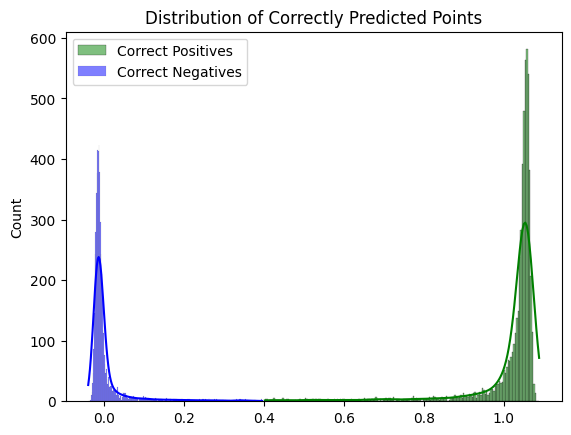

In [35]:
# Plotting correctly predicted positive and negative points
sns.histplot(val_predictions[correct_pos], kde=True, color='green', label='Correct Positives')
sns.histplot(val_predictions[correct_neg], kde=True, color='blue', label='Correct Negatives')
plt.title('Distribution of Correctly Predicted Points')
plt.legend()
plt.show()

In [36]:
# Identifying incorrect predictions based on threshold
incorrect_pos = val_predictions[(val_labels == 1) & (val_predictions < best_threshold)]
incorrect_neg = val_predictions[(val_labels == 0) & (val_predictions >= best_threshold)]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


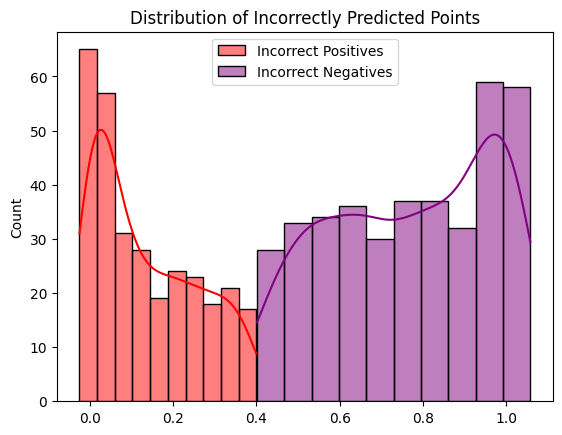

In [37]:
# Plotting incorrectly predicted positive and negative points
sns.histplot(incorrect_pos, kde=True, color='red', label='Incorrect Positives')
sns.histplot(incorrect_neg, kde=True, color='purple', label='Incorrect Negatives')
plt.title('Distribution of Incorrectly Predicted Points')
plt.legend()
plt.show()

In [11]:
import torch
from transformers import AutoModelForSequenceClassification,BertTokenizer
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")
model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.2",
    num_labels=1
)

model.eval() 
# Load BioBERT weights from checkpoint
try:
    checkpoint_path = "./biobert/checkpoint.pth"
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("BioBERT model weights loaded successfully.")
except Exception as e:
    print(f"Error loading BioBERT checkpoint: {e}")
model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Ikshvaku Rastogi\AppData\Local\Temp\ipykernel_5964\1560349402.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by th

BioBERT model weights loaded successfully.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Function to prepare inputs and extract embeddings
def extract_embeddings(text, model, tokenizer, max_length=512):
    # Tokenize the input text
    inputs = tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
    input_ids = inputs['input_ids'].to('cuda')
    attention_mask = inputs['attention_mask'].to('cuda')
    
    # Get embeddings from hidden states of the last layer
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        # Use the last hidden state as sentence embeddings, averaging across tokens
        last_hidden_state = outputs.hidden_states[-1]  # Get last layer
        embeddings = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    
    return embeddings

In [13]:
# Wrapper function for question embeddings
def extract_question_embed(question):
    return extract_embeddings(question, model, tokenizer)

# Wrapper function for answer embeddings
def extract_answer_embed(answer):
    return extract_embeddings(answer, model, tokenizer)

In [14]:
pos_train = train_df[train_df['label']==1].copy()
pos_val = val_df[val_df['label']==1].copy()

In [15]:
# Convert data to lists for ease of processing
train_questions = pos_train['question'].tolist()
train_answers = pos_train['answer'].tolist()
val_questions = pos_val['question'].tolist()
val_answers = pos_val['answer'].tolist()
train_labels = pos_train['label'].tolist()
val_labels = pos_val['label'].tolist()

In [17]:
import pandas as pd
from tqdm.notebook import tqdm

# Extract and save train question embeddings
train_question_embeddings = [extract_question_embed([q]) for q in tqdm(train_questions)]
train_answer_embeddings = [extract_answer_embed([a]) for a in tqdm(train_answers)]

  0%|          | 0/23802 [00:00<?, ?it/s]

  0%|          | 0/23802 [00:00<?, ?it/s]

In [18]:
# Extract and save validation question embeddings
val_question_embeddings = [extract_question_embed([q]) for q in tqdm(val_questions)]
val_answer_embeddings = [extract_answer_embed([a]) for a in tqdm(val_answers)]

  0%|          | 0/5950 [00:00<?, ?it/s]

  0%|          | 0/5950 [00:00<?, ?it/s]

In [21]:
pos_train['question_embeddings'] = train_question_embeddings

In [22]:
pos_train['answer_embeddings'] = train_answer_embeddings

In [24]:
pos_val['question_embeddings'] = val_question_embeddings
pos_val['answer_embeddings'] = val_answer_embeddings

In [29]:
pos_train.drop('label',axis=1).to_pickle('./biobert/train_embeddings.pkl')
pos_val.drop('label',axis=1).to_pickle('./biobert/val_embeddings.pkl')

In [30]:
pos_train.columns

Index(['question', 'answer', 'label', 'question_embeddings',
       'answer_embeddings'],
      dtype='object')

In [31]:
pos_val.columns

Index(['question', 'answer', 'label', 'question_embeddings',
       'answer_embeddings'],
      dtype='object')

In [32]:
# Saving to disk
np.save('train_numpy_embeddings.npy', pos_train.drop('label',axis=1).to_numpy())
np.save('val_numpy_embeddings.npy', pos_val.drop('label',axis=1).to_numpy())